In [ ]:
import dask.dataframe as dd

df = dd.read_parquet('df_clustered.parquet')
df.head()

,id,abstract_clean,cluster_x,cluster_y
0,https://openalex.org/W3048280953,The notion that the immune system can be manip...,498,498
1,https://openalex.org/W2370857924,LIM domain-binding protein 1 (Ldb1) is a nucle...,0,0
2,https://openalex.org/W2166587078,Patients undergoing arthroplasty surgery are r...,326,326
3,https://openalex.org/W3029081899,"Objective To explore the clinical features, p...",604,604
4,https://openalex.org/W2887453391,"In March 2017, waiting times for an outpatient...",326,326


In [ ]:
df = df.rename(columns={'cluster_x': 'cluster'})
df = df.drop('cluster_y', axis=1)

In [ ]:
import pandas as pd
df_pd = df[['id','abstract_clean', 'cluster']].dropna().compute()

In [ ]:
cluster_texts = df_pd.groupby("cluster")["abstract_clean"].apply(lambda x: " ".join(x)).reset_index()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.9,
    min_df=2,
    max_features=1000
)

X = vectorizer.fit_transform(cluster_texts["abstract_clean"])
feature_names = vectorizer.get_feature_names_out()


In [ ]:
import pandas as pd
import numpy as np

top_n = 15
data = []

# Loop over each cluster row in the TF-IDF matrix
for row in X:
    row_array = row.toarray().flatten()
    top_indices = row_array.argsort()[-top_n:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = [row_array[i] for i in top_indices]
    data.append(list(zip(top_words, top_scores)))

# Create a styled DataFrame
def format_entry(word_score_tuple):
    word, score = word_score_tuple
    return f"{word} ({score:.3f})"

styled_df = pd.DataFrame(data)
styled_df.columns = [f"Keyword {i+1}" for i in range(top_n)]
styled_df.insert(0, "Cluster", cluster_texts["cluster"].values)
styled_df_keywords_only = styled_df.drop(columns="Cluster").applymap(format_entry)

# Extract score matrix for coloring
score_matrix = pd.DataFrame([
    [score for _, score in row] for row in data
], columns=[f"Keyword {i+1}" for i in range(top_n)])

# Function to apply background gradient
styled = styled_df_keywords_only.style.background_gradient(
    cmap='YlGnBu',
    axis=None,
    subset=styled_df_keywords_only.columns,
    gmap=score_matrix
)

# Add cluster column back
styled = styled.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).set_properties(**{'text-align': 'left'})

# Display the full table with color
styled_df_keywords_only.insert(0, "Cluster", cluster_texts["cluster"].values)
styled


<ipython-input-6-3f5cb5d5dbbd>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  styled_df_keywords_only = styled_df.drop(columns="Cluster").applymap(format_entry)


In [ ]:
from pydantic import BaseModel
from tqdm import tqdm
import time
import json
import pandas as pd
from openai import OpenAI
import private_info

top_n = 15
data = []

for row in X:
    row_array = row.toarray().flatten()
    top_indices = row_array.argsort()[-top_n:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = [row_array[i] for i in top_indices]
    data.append(list(zip(top_words, top_scores)))

# Assign the new column
cluster_texts["keyword_score_pairs"] = data


# Initialize OpenAI client
client = OpenAI(api_key=private_info.openAI_api_key)

# === Define output schema ===
class TopicLabel(BaseModel):
    topic: str  # short topic name
    note: str   # one-sentence explanation

# === Prompt builder ===
def create_topic_prompt(cluster_id, keyword_score_pairs):
    keywords_str = ", ".join([f"{kw} ({score:.3f})" for kw, score in keyword_score_pairs])
    prompt = f"""
      You are assigning a domain-level topic to a group of medical research papers, based on keywords extracted using TF-IDF.

      These keywords are drawn from abstracts within a single cluster. Your goal is to name **broad topical areas** (e.g., "oncology", "cardiovascular medicine", "infectious diseases", "geriatrics") rather than specific mechanisms or study types.

      Only generate:
      - "topic": a **broad medical field** label (1 to 4 words max)
      - "note": a short explanation of how the keywords connect to that domain

      If the keywords are too scattered or ambiguous, set:
      - "topic": "other"
      - "note": "Keywords too broad or unclear for classification"

      Keywords: {keywords_str}
    """
    return prompt


# === Main loop ===
topic_results = []

for i, row in tqdm(cluster_texts.iterrows(), total=len(cluster_texts)):
    try:
        cluster_id = row["cluster"]
        kw_scores = row["keyword_score_pairs"]
        prompt = create_topic_prompt(cluster_id, kw_scores)

        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[
                {"role": "system", "content": "You are a concise and accurate topic labeler for research clusters."},
                {"role": "user", "content": prompt}
            ],
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "labeling",
                    "schema": TopicLabel.model_json_schema()
                }
            },
            temperature=0,
            max_tokens=300
        )

        # Parse structured result
        parsed = json.loads(response.choices[0].message.content)

        topic_results.append({
            "cluster": cluster_id,
            "topic": parsed["topic"],
            "reason": parsed["note"]  # <- this must match the schema field
        })

        time.sleep(0.3)  # to avoid rate limit

    except Exception as e:
        # Optional: print out the raw message for debugging
        print(f"[ERROR] Cluster {row['cluster']} - {e}")
        topic_results.append({
            "cluster": row["cluster"],
            "topic": "ERROR",
            "reason": str(e)
        })

# === Convert to DataFrame and Merge ===
topic_df = pd.DataFrame(topic_results)
topic_df


100%|██████████| 825/825 [18:13<00:00,  1.33s/it]


,cluster,topic,reason
0,0,immunology,"Keywords such as 'cells', 'inflammatory', 'gen..."
1,1,oncology,Keywords such as 'hcc' (hepatocellular carcino...
2,2,molecular medicine,"Keywords like 'expression', 'rna', 'genome', a..."
3,3,oncology,"Keywords such as 'cancer', 'tumor', 'mutation'..."
4,4,oncology,"Keywords such as 'hcc', 'carcinoma', 'tumor', ..."
...,...,...,...
820,820,infectious diseases,"Keywords focus on viral mutations, SARS-CoV, a..."
821,821,endocrinology,"Keywords focus on diabetes, glucose, and predi..."
822,822,neuropsychology,"Keywords such as 'cognitive', 'learning', 'tra..."
823,823,oncology,"Keywords such as 'tumor', 'tumors', 'gene', 'v..."


In [ ]:
# Merge topic information back to the original DataFrame
clustered_df = pd.merge(df_pd, topic_df, on='cluster', how='left')

# Save the updated DataFrame to parquet
clustered_df.to_parquet('clustered_df_title2.parquet')


In [ ]:
clustered_df[-10:]

,id,abstract_clean,cluster,topic,reason
1117152,https://openalex.org/W2609841933,The BRAF protein kinase is widely studied as a...,498,oncology,"Keywords focus on cancer, tumors, specific can..."
1117153,https://openalex.org/W4400854629,Introduction: Obstructive sleep apnea (OSA) ex...,773,rehabilitation medicine,"Keywords emphasize pain, stroke, physical acti..."
1117154,https://openalex.org/W4381046847,Abstract Background Some data suggest that low...,399,endocrinology,"Keywords focus on diabetes, glucose, insulin, ..."
1117155,https://openalex.org/W2895919606,Despite compelling evidence regarding its safe...,696,oncology,"Keywords focus on various cancers (prostate, b..."
1117156,https://openalex.org/W4323863594,The purpose of this study was to examine the e...,773,rehabilitation medicine,"Keywords emphasize pain, stroke, physical acti..."
1117157,https://openalex.org/W2597113820,Stroke remains the leading cause of death and ...,16,neurology,"Keywords like 'brain', 'ms' (multiple sclerosi..."
1117158,https://openalex.org/W4392387726,(1) Background: Dry eye disease (DED) is a mul...,163,ophthalmology,"Keywords like 'visual', 'surgery', and 'diabet..."
1117159,https://openalex.org/W3199103319,This study aimed to assess the prevalence and ...,399,endocrinology,"Keywords focus on diabetes, glucose, insulin, ..."
1117160,https://openalex.org/W4393080753,Abstract Background There is a growing populat...,346,infectious diseases,"The prominence of 'HIV', 'testing', 'viral', a..."
1117161,https://openalex.org/W3013136096,"Study design Pilot, multicentre randomised cli...",326,orthopedic surgery,"Keywords focus on knee, bone, joint, fractures..."


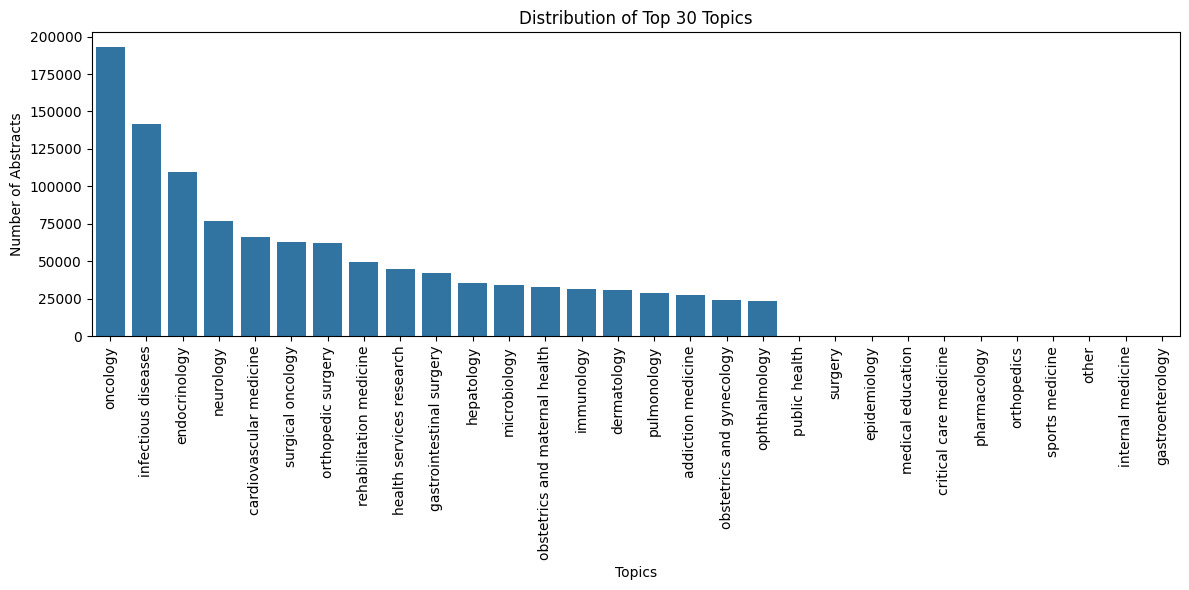

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each topic
topic_counts = clustered_df['topic'].value_counts()

# Keep only the top 30 topics
top_30_topics = topic_counts.head(30)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_30_topics.index, y=top_30_topics.values)
plt.xticks(rotation=90)
plt.xlabel("Topics")
plt.ylabel("Number of Abstracts")
plt.title("Distribution of Top 30 Topics")
plt.tight_layout()
plt.show()


## Tidy up the dataset

In [ ]:
import dask.dataframe as dd

df_main = dd.read_parquet('checkpoint_datacleaning2')
print(df_main.columns.tolist())


['abstract_inverted_index', 'apc_list', 'apc_paid', 'authors_count', 'cited_by_api_url', 'cited_by_count', 'cited_by_percentile_year', 'concepts_count', 'corresponding_author_ids', 'corresponding_institution_ids', 'countries_distinct_count', 'counts_by_year', 'created_date', 'datasets', 'display_name', 'doi', 'institutions_distinct_count', 'is_oa_flag', 'is_retracted', 'journal_issn', 'journal_title', 'keywords', 'language', 'locations', 'locations_count', 'mesh', 'publication_year', 'referenced_works', 'related_works', 'title', 'topics_count', 'type_crossref', 'type_id', 'updated', 'updated_date', 'versions', 'prim_topic', 'prim_field', 'prim_domain', 'prim_score', 'missing_abstract', 'is_aging']


In [ ]:
import pandas as pd
clustered_df = pd.read_parquet('clustered_df_title2.parquet')

In [ ]:
clustered_df['topic'].unique()

array(['oncology', 'immunology', 'orthopedic surgery',
       'gastrointestinal surgery', 'rehabilitation medicine',
       'endocrinology', 'neurology', 'surgical oncology', 'pulmonology',
       'obstetrics and gynecology', 'cardiovascular medicine',
       'infectious diseases', 'dermatology', 'hepatology',
       'health services research', 'addiction medicine',
       'obstetrics and maternal health', 'ophthalmology', 'surgery',
       'microbiology', 'clinical research', 'general medicine',
       'hematology oncology', 'other', 'endocrinology and metabolism',
       'cardiology', 'internal medicine', 'molecular medicine',
       'public health', 'immuno-oncology', 'orthopedics', 'nephrology',
       'genetics', 'sports medicine', 'diagnostic medicine',
       'genetic disorders', 'pediatric medicine', 'medical education',
       'clinical trials', 'radiology', 'general internal medicine',
       'anesthesiology', 'preventive medicine', 'critical care medicine',
       'musculosk

In [ ]:
df_doi_fwci = dd.read_parquet('doi_id_fwci_mapping')
df_doi_fwci.head()

,doi,id,fwci
0,https://doi.org/10.30773/pi.2023.0285,https://openalex.org/W4398780515,0.0
1,https://doi.org/10.3390/jcm13113073,https://openalex.org/W4398783407,0.0
2,https://doi.org/10.1136/bmjoq-2023-002638,https://openalex.org/W4398785644,0.0
3,https://doi.org/10.5114/pjp.2024.139609,https://openalex.org/W4398787321,0.0
4,https://doi.org/10.1016/j.sopen.2024.05.012,https://openalex.org/W4399116614,0.0


In [ ]:
df_main = df_main.merge(df_doi_fwci, on="doi", how="left")

In [ ]:
selected_columns = ['id', 'doi', 'title', 'publication_year', 'countries_distinct_count', 'institutions_distinct_count', 'cited_by_count',  'cited_by_percentile_year',
 'keywords', 'counts_by_year', 'journal_issn', 'fwci',
 'journal_title', 'prim_topic', 'prim_field', 'prim_domain', 'prim_score', 'missing_abstract',
 'is_aging']

df_main = df_main[selected_columns].compute()

df_main.head()


,id,doi,title,publication_year,countries_distinct_count,institutions_distinct_count,cited_by_count,cited_by_percentile_year,keywords,counts_by_year,journal_issn,fwci,journal_title,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging
0,https://openalex.org/W4301041367,https://doi.org/10.37549/ar2459,Acute perforated acalculous cholecystitis,2018,1,1,2,"{'min': 70, 'max': 74}",[],"[{'year': 2022, 'cited_by_count': 1}, {'year':...",0160-9963,0.201,Applied Radiology,Gallbladder and Bile Duct Disorders,Medicine,Health Sciences,0.9999,True,NaN
1,https://openalex.org/W3134475915,https://doi.org/10.4084/mjhid.2021.022,Mild clinical course of COVID-19 infection in ...,2021,1,1,6,"{'min': 80, 'max': 82}",[{'id': 'https://openalex.org/keywords/2019-20...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",2035-3006,0.609,Mediterranean Journal of Hematology and Infect...,COVID-19 and healthcare impacts,Medicine,Health Sciences,0.9931,True,NaN
2,https://openalex.org/W2579544162,https://doi.org/10.11569/wcjd.v23.i29.4720,Clinical application of double plasma molecula...,2015,0,0,0,"{'min': 0, 'max': 66}",[],[],1009-3079,0.0,World Chinese Journal of Digestology,Hepatitis C virus research,Medicine,Health Sciences,0.8271,True,NaN
3,https://openalex.org/W3010386217,https://doi.org/10.1016/j.jcin.2019.12.006,Prior Balloon Valvuloplasty Versus Direct Tran...,2020,1,12,40,"{'min': 96, 'max': 97}",[{'id': 'https://openalex.org/keywords/aortic-...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",1876-7605,4.754,JACC: Cardiovascular Interventions,Cardiac Valve Diseases and Treatments,Medicine,Health Sciences,0.9998,True,NaN
4,https://openalex.org/W2993483701,https://doi.org/10.29060/taps.2020-5-1/ra2087,Establishing and sustaining a transnational cl...,2019,1,1,3,"{'min': 74, 'max': 77}",[{'id': 'https://openalex.org/keywords/faculty...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",2424-9270,0.235,Asia Pacific Scholar,Innovations in Medical Education,Medicine,Health Sciences,0.9996,True,NaN


In [ ]:
df_main['is_aging'].value_counts()

,count
is_aging,
1.0,1531574
0.0,101963


In [ ]:
# Merge 'topic' column from clustered_df into df_main
df_main = df_main.merge(clustered_df[['id', 'topic']], on='id', how='left')
df_main.head()

,id,doi,title,publication_year,countries_distinct_count,institutions_distinct_count,cited_by_count,cited_by_percentile_year,keywords,counts_by_year,journal_issn,fwci,journal_title,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging,topic
0,https://openalex.org/W4301041367,https://doi.org/10.37549/ar2459,Acute perforated acalculous cholecystitis,2018,1,1,2,"{'min': 70, 'max': 74}",[],"[{'year': 2022, 'cited_by_count': 1}, {'year':...",0160-9963,0.201,Applied Radiology,Gallbladder and Bile Duct Disorders,Medicine,Health Sciences,0.9999,True,NaN,NaN
1,https://openalex.org/W3134475915,https://doi.org/10.4084/mjhid.2021.022,Mild clinical course of COVID-19 infection in ...,2021,1,1,6,"{'min': 80, 'max': 82}",[{'id': 'https://openalex.org/keywords/2019-20...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",2035-3006,0.609,Mediterranean Journal of Hematology and Infect...,COVID-19 and healthcare impacts,Medicine,Health Sciences,0.9931,True,NaN,NaN
2,https://openalex.org/W2579544162,https://doi.org/10.11569/wcjd.v23.i29.4720,Clinical application of double plasma molecula...,2015,0,0,0,"{'min': 0, 'max': 66}",[],[],1009-3079,0.0,World Chinese Journal of Digestology,Hepatitis C virus research,Medicine,Health Sciences,0.8271,True,NaN,NaN
3,https://openalex.org/W3010386217,https://doi.org/10.1016/j.jcin.2019.12.006,Prior Balloon Valvuloplasty Versus Direct Tran...,2020,1,12,40,"{'min': 96, 'max': 97}",[{'id': 'https://openalex.org/keywords/aortic-...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",1876-7605,4.754,JACC: Cardiovascular Interventions,Cardiac Valve Diseases and Treatments,Medicine,Health Sciences,0.9998,True,NaN,NaN
4,https://openalex.org/W2993483701,https://doi.org/10.29060/taps.2020-5-1/ra2087,Establishing and sustaining a transnational cl...,2019,1,1,3,"{'min': 74, 'max': 77}",[{'id': 'https://openalex.org/keywords/faculty...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",2424-9270,0.235,Asia Pacific Scholar,Innovations in Medical Education,Medicine,Health Sciences,0.9996,True,NaN,NaN


In [ ]:
df_main['topic'].unique()

array([nan, 'surgical oncology', 'rehabilitation medicine',
       'endocrinology', 'hepatology', 'obstetrics and gynecology',
       'ophthalmology', 'dermatology', 'oncology',
       'health services research', 'gastrointestinal surgery',
       'immunology', 'infectious diseases', 'orthopedic surgery',
       'microbiology', 'cardiovascular medicine',
       'obstetrics and maternal health', 'addiction medicine',
       'neurology', 'pulmonology', 'sports medicine', 'medical imaging',
       'orthopedics', 'general medicine', 'oral health',
       'endocrinology and metabolism', 'epidemiology',
       'medical education', 'clinical epidemiology', 'surgery',
       'pharmacology', 'clinical medicine', 'medical informatics',
       'public health', 'molecular medicine', 'molecular oncology',
       'plastic surgery', 'pulmonology oncology', 'gastroenterology',
       'other', 'maternal and child health', 'internal medicine',
       'critical care medicine', 'clinical pharmacology',
  

In [ ]:
# Add the if condition to assign the topic
df_main.loc[df_main['is_aging'] == 0, 'topic'] = 'aging'

In [ ]:
df_main['topic'].unique()

array([nan, 'surgical oncology', 'rehabilitation medicine',
       'endocrinology', 'aging', 'hepatology',
       'obstetrics and gynecology', 'ophthalmology', 'dermatology',
       'oncology', 'health services research', 'gastrointestinal surgery',
       'immunology', 'infectious diseases', 'orthopedic surgery',
       'microbiology', 'cardiovascular medicine',
       'obstetrics and maternal health', 'addiction medicine',
       'neurology', 'pulmonology', 'sports medicine', 'medical imaging',
       'orthopedics', 'general medicine', 'oral health',
       'endocrinology and metabolism', 'epidemiology',
       'medical education', 'clinical epidemiology', 'surgery',
       'pharmacology', 'clinical medicine', 'medical informatics',
       'public health', 'molecular medicine', 'molecular oncology',
       'plastic surgery', 'pulmonology oncology', 'gastroenterology',
       'other', 'maternal and child health', 'internal medicine',
       'critical care medicine', 'clinical pharmaco

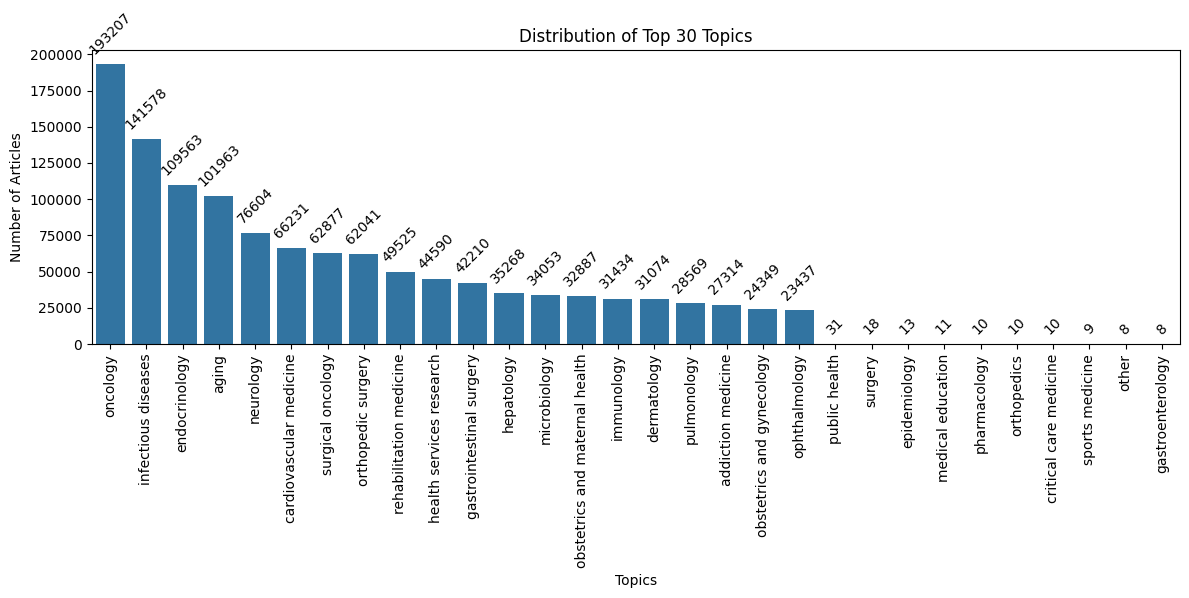

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_num = 30

# Count topic occurrences
topic_counts = df_main['topic'].value_counts()

# Get top N topics sorted by frequency
top_topics = topic_counts.head(top_num)
sorted_index = top_topics.sort_values(ascending=False).index  # ensure descending sort

# Create bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_topics.index, y=top_topics.values, order=sorted_index)
plt.xticks(rotation=90)
plt.xlabel("Topics")
plt.ylabel("Number of Articles")
plt.title(f"Distribution of Top {top_num} Topics")

# Add frequency labels above bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points',
                rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming 'clustered_df' is already defined from the previous code
topic_counts = df_main['topic'].value_counts()

# Filter topics with frequency less than 100
less_than_100 = topic_counts[topic_counts < 100]

# Print the topics
dict(less_than_100)


{'public health': np.int64(31),
 'surgery': np.int64(18),
 'epidemiology': np.int64(13),
 'medical education': np.int64(11),
 'pharmacology': np.int64(10),
 'orthopedics': np.int64(10),
 'critical care medicine': np.int64(10),
 'sports medicine': np.int64(9),
 'other': np.int64(8),
 'gastroenterology': np.int64(8),
 'clinical research': np.int64(8),
 'internal medicine': np.int64(8),
 'endocrinology and metabolism': np.int64(7),
 'nephrology': np.int64(7),
 'maternal and child health': np.int64(6),
 'pediatrics': np.int64(6),
 'general medicine': np.int64(6),
 'obstetrics': np.int64(6),
 'hematology': np.int64(6),
 'cardiology': np.int64(6),
 'anesthesiology': np.int64(5),
 'radiology': np.int64(5),
 'genetic medicine': np.int64(5),
 'diagnostic medicine': np.int64(5),
 'pediatric medicine': np.int64(5),
 'genetics': np.int64(4),
 'pain management': np.int64(4),
 'molecular medicine': np.int64(4),
 'psychiatry': np.int64(4),
 'clinical trials': np.int64(3),
 'musculoskeletal medicine':

In [ ]:
# Assuming 'clustered_df' and 'topic_counts' are already defined from the previous code
topic_counts = df_main['topic'].value_counts()

# Filter topics with frequency greater than or equal to 100
more_than_100 = topic_counts[topic_counts >= 100]

# Print the topics
more_than_100


,count
topic,
oncology,193207
infectious diseases,141578
endocrinology,109563
aging,101963
neurology,76604
cardiovascular medicine,66231
surgical oncology,62877
orthopedic surgery,62041
rehabilitation medicine,49525


In [ ]:
import pandas as pd
import numpy as np

# Your major categories
major_categories = [
   "oncology",
   "infectious diseases",
  "endocrinology",
  "aging",
  "neurology",
  "cardiovascular medicine",
  "surgical oncology",
  "orthopedic surgery",
  "rehabilitation medicine",
  "health services research",
  "gastrointestinal surgery",
  "hepatology",
  "microbiology",
  "obstetrics and maternal health",
  "immunology",
  "dermatology",
  "pulmonology",
  "addiction medicine",
  "obstetrics and gynecology",
  "ophthalmology",


]

# Mapping from minor to major topics
merge_map = {
    # Endocrinology and metabolism
    "endocrinology": "endocrinology",
    "diabetes": "endocrinology",
    "metabolic diseases": "endocrinology",
    "nutrition and metabolism": "endocrinology",
    "pediatric endocrinology": "endocrinology",
    "pharmacology": "endocrinology",
    "clinical pharmacology": "endocrinology",

    # Obstetrics and gynecology
    "obstetrics": "obstetrics and gynecology",
    "maternal health": "obstetrics and gynecology",
    "maternal and child health": "obstetrics and gynecology",
    "maternal and perinatal health": "obstetrics and gynecology",
    "obstetrics and maternal health": "obstetrics and gynecology",

    # Oncology
    "gynecologic oncology": "oncology",
    "urologic oncology": "oncology",
    "hematology": "oncology",
    "molecular medicine": "oncology",
    "molecular oncology": "oncology",
    "immuno-oncology": "oncology",
    "psycho-oncology": "oncology",
    "genetic medicine": "oncology",
    "genetics and genomics": "oncology",
    "genetics": "oncology",
    "genetic disorders": "oncology",
    "genetic epidemiology": "oncology",

    # Infectious diseases
    "public health": "infectious diseases",
    "epidemiology": "infectious diseases",
    "clinical epidemiology": "infectious diseases",
    "pediatric infectious diseases": "infectious diseases",
    "HIV/AIDS medicine": "infectious diseases",
    "public health epidemiology": "infectious diseases",

    # Psychiatry
    "mental health": "psychiatry",
    "neuropsychology": "psychiatry",

    # Cardiovascular medicine
    "cardiology": "cardiovascular medicine",
    "vascular medicine": "cardiovascular medicine",

    # Orthopedic surgery
    "orthopedics": "orthopedic surgery",
    "musculoskeletal medicine": "orthopedic surgery",
    "sports medicine": "orthopedic surgery",
    "trauma and orthopedics": "orthopedic surgery",

    # Surgery
    "cardiovascular surgery": "surgery",
    "neurosurgery": "surgery",
    "plastic surgery": "surgery",
    "trauma medicine": "surgery",
    "trauma and injury medicine": "surgery",
    "breast surgery": "surgery",
    "vascular surgery": "surgery",

    # Pulmonology
    "pulmonology oncology": "pulmonology",
    "sleep medicine": "pulmonology",

    # Critical care medicine
    "emergency medicine": "critical care medicine",
    "pediatric critical care": "critical care medicine",

    # General clinical research
    "clinical trials": "general clinical research",
    "clinical research": "general clinical research",
    "clinical outcomes research": "general clinical research",
    "internal medicine": "general clinical research",
    "general medicine": "general clinical research",
    "clinical medicine": "general clinical research",
    "hospital medicine": "general clinical research",
    "primary care": "general clinical research",

    # Addiction medicine
    "palliative care": "addiction medicine",

    # Other
    "radiology": "other",
    "medical imaging": "other",
    "cell biology": "other",
    "molecular biology": "other",
    "biomarker research": "other",
    "exercise physiology": "other",
    "nutrition": "other",
    "nutrition and dietetics": "other",
    "medical diagnostics": "other",
    "behavioral medicine": "other",
    "clinical measurement": "other",
    "reproductive medicine": "other",
    "traditional medicine": "other",
    "experimental medicine": "other",
    "sleep medicine": "other",
    "diagnostic medicine": "other",
    "general biomedical research": "other",
    "medical informatics": "other",
    "clinical research methods": "other",
    "preclinical research": "other",
}

# Step 1: Map minor topics → use mapping only if the topic is not already a major category
df_main['topic_cleaned'] = df_main['topic'].apply(
    lambda x: merge_map.get(x, x) if pd.notna(x) else x
)

# Step 2: Ensure values not in major categories get mapped to "other"
df_main['topic_cleaned'] = df_main['topic_cleaned'].apply(
    lambda x: x if pd.isna(x) or str(x) in major_categories else "other"
)



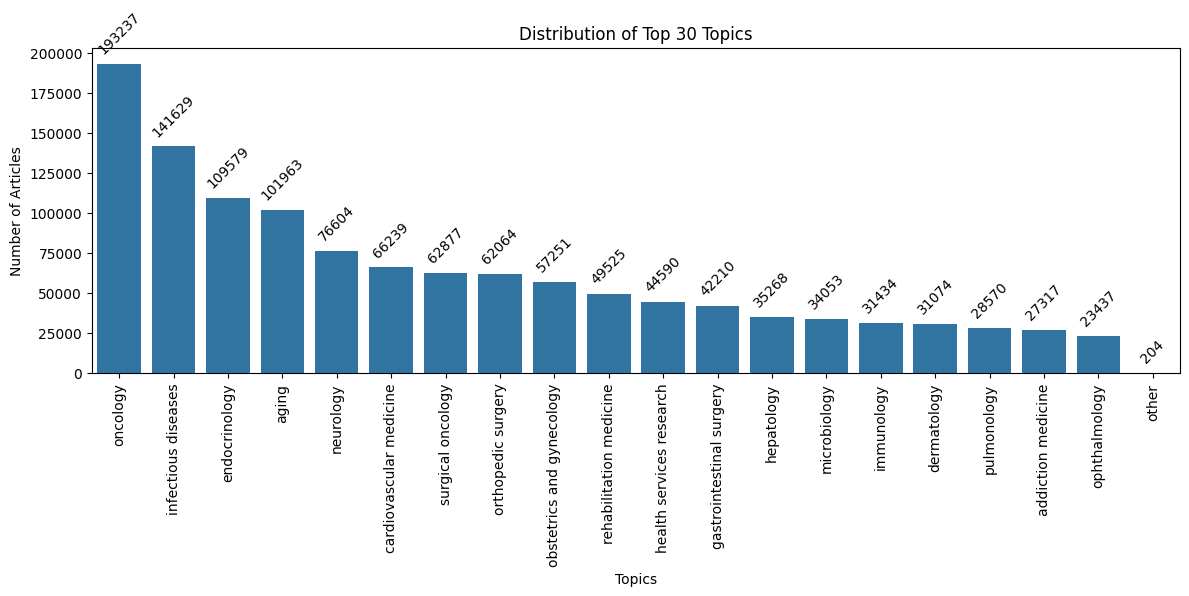

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_num = 30

# Count topic occurrences
topic_counts = df_main['topic_cleaned'].value_counts()

# Get top N topics sorted by frequency
top_topics = topic_counts.head(top_num)
sorted_index = top_topics.sort_values(ascending=False).index  # ensure descending sort

# Create bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_topics.index, y=top_topics.values, order=sorted_index)
plt.xticks(rotation=90)
plt.xlabel("Topics")
plt.ylabel("Number of Articles")
plt.title(f"Distribution of Top {top_num} Topics")

# Add frequency labels above bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points',
                rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
df_main['topic_cleaned'].unique()

array([nan, 'surgical oncology', 'rehabilitation medicine',
       'endocrinology', 'aging', 'hepatology',
       'obstetrics and gynecology', 'ophthalmology', 'dermatology',
       'oncology', 'health services research', 'gastrointestinal surgery',
       'immunology', 'infectious diseases', 'orthopedic surgery',
       'microbiology', 'cardiovascular medicine', 'addiction medicine',
       'neurology', 'pulmonology', 'other'], dtype=object)

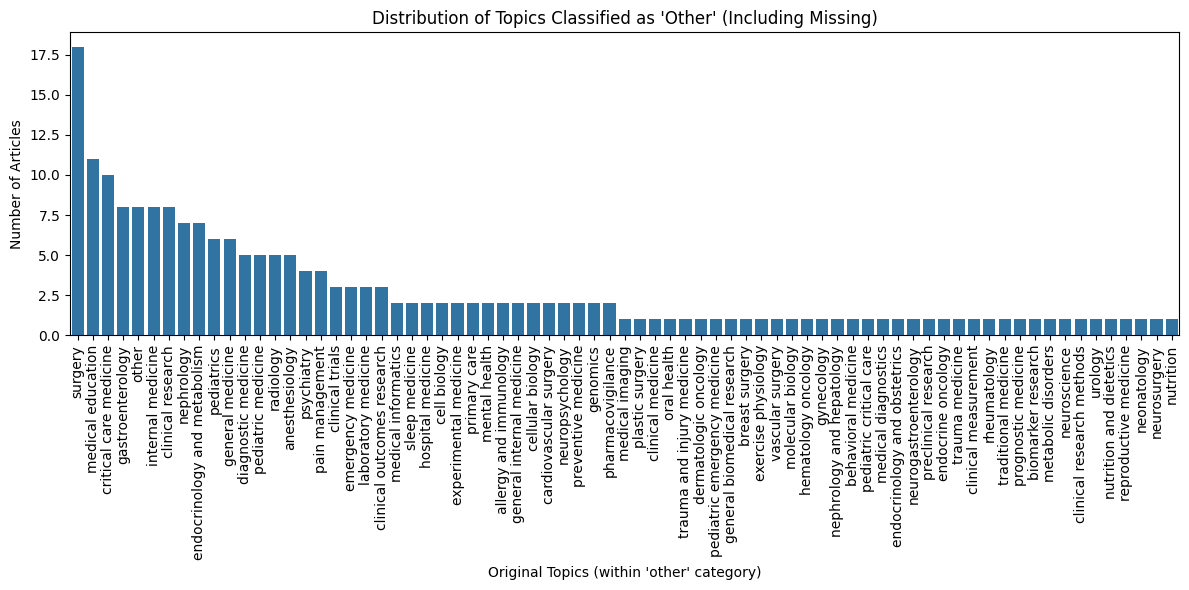

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for 'other' topics
other_topics_df = df_main[df_main['topic_cleaned'] == 'other']

# Count all topic values, including NaNs
other_topic_counts = other_topics_df['topic'].value_counts(dropna=False)

# Replace NaN index with a readable label
other_topic_counts.index = other_topic_counts.index.fillna('Missing')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=other_topic_counts.index, y=other_topic_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Original Topics (within 'other' category)")
plt.ylabel("Number of Articles")
plt.title("Distribution of Topics Classified as 'Other' (Including Missing)")
plt.tight_layout()
plt.show()


In [ ]:
main_topics = [
    'surgical oncology', 'rehabilitation medicine', 'endocrinology', 'aging',
    'hepatology', 'obstetrics and gynecology', 'ophthalmology', 'dermatology',
    'oncology', 'health services research', 'gastrointestinal surgery',
    'immunology', 'infectious diseases', 'orthopedic surgery', 'microbiology',
    'cardiovascular medicine', 'addiction medicine', 'neurology',
    'pulmonology', 'other'
]

second_stage_map = {
    # Map leftover surgical subfields
    "surgery": "gastrointestinal surgery",  # or keep as "general surgery"
    "plastic surgery": "surgical oncology",
    "breast surgery": "surgical oncology",
    "cardiovascular surgery": "cardiovascular medicine",
    "neurosurgery": "neurology",
    "vascular surgery": "cardiovascular medicine",
    "trauma and injury medicine": "orthopedic surgery",
    "trauma medicine": "orthopedic surgery",

    # GI / hepatology
    "gastroenterology": "gastrointestinal surgery",
    "neurogastroenterology": "gastrointestinal surgery",
    "nephrology and hepatology": "hepatology",

    # Infectious disease / immunology
    "emergency medicine": "infectious diseases",
    "preventive medicine": "infectious diseases",
    "allergy and immunology": "immunology",
    "mental health": "addiction medicine",  # or "psychiatry" if you prefer

    # Oncology variants
    "dermatologic oncology": "oncology",
    "endocrine oncology": "oncology",
    "hematology oncology": "oncology",
    "biomarker research": "oncology",

    # Pediatric mapping
    "pediatrics": "obstetrics and gynecology",
    "pediatric medicine": "obstetrics and gynecology",
    "neonatology": "obstetrics and gynecology",
    "pediatric emergency medicine": "infectious diseases",
    "pediatric critical care": "infectious diseases",

    # Clinical practice / services
    "internal medicine": "health services research",
    "general medicine": "health services research",
    "hospital medicine": "health services research",
    "clinical research": "health services research",
    "clinical medicine": "health services research",
    "clinical trials": "health services research",
    "clinical outcomes research": "health services research",
    "clinical research methods": "health services research",
    "general internal medicine": "health services research",
    "primary care": "health services research",
    "laboratory medicine": "health services research",
    "medical education": "health services research",
    "medical diagnostics": "health services research",
    "clinical measurement": "health services research",

    # Endocrinology / nutrition
    "nutrition": "endocrinology",
    "nutrition and dietetics": "endocrinology",
    "endocrinology and metabolism": "endocrinology",
    "endocrinology and obstetrics": "endocrinology",
    "metabolic disorders": "endocrinology",

    # Neuroscience-related
    "neuropsychology": "neurology",
    "neuroscience": "neurology",

    # Imaging
    "radiology": "immunology",
    "medical imaging": "immunology",

    # Pain
    "pain management": "addiction medicine",
    "anesthesiology": "addiction medicine",

    # Edge fields
    "psychiatry": "addiction medicine",
    "behavioral medicine": "addiction medicine",
    "reproductive medicine": "obstetrics and gynecology",
    "gynecology": "obstetrics and gynecology",

     "surgical oncology": "surgery",
    "gastrointestinal surgery": "surgery",
    "breast surgery": "surgery",
    "cardiovascular surgery": "surgery",
    "vascular surgery": "surgery",
    "plastic surgery": "surgery",
    "neurosurgery": "surgery",
    "trauma and injury medicine": "surgery",
    "trauma medicine": "surgery",
    "orthopedic surgery": "surgery"
}

# Only remap those currently labeled as "other"
def refine_other(row):
    if row['topic_cleaned'] == "other":
        return second_stage_map.get(str(row['topic']).strip(), "other")
    else:
        return row['topic_cleaned']

df_main['topic_cleaned'] = df_main.apply(refine_other, axis=1)


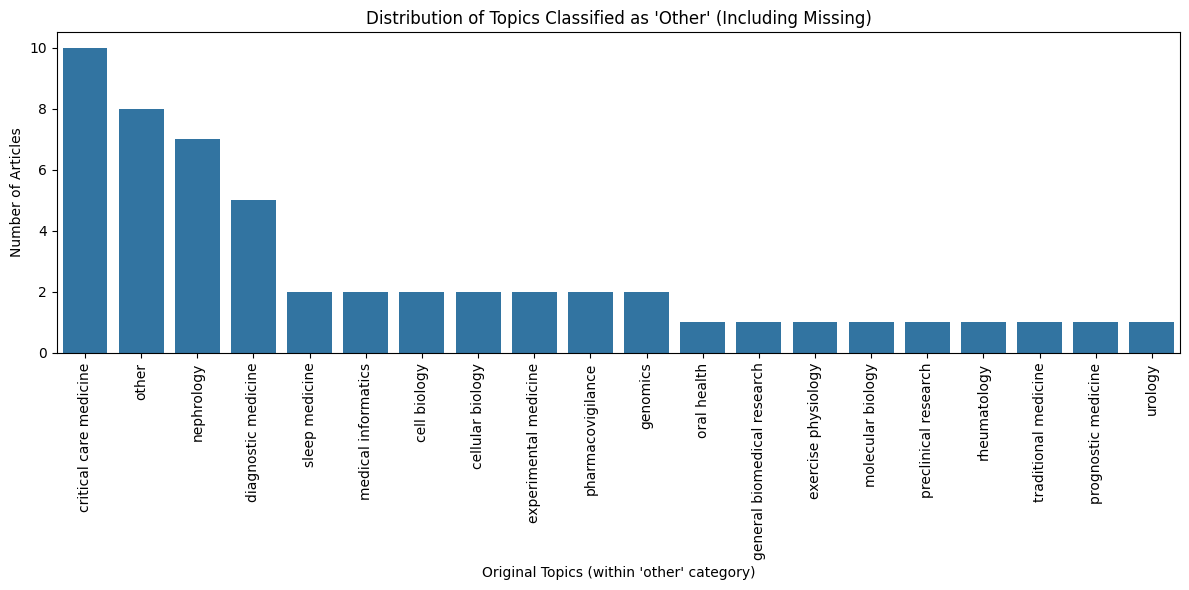

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for 'other' topics
other_topics_df = df_main[df_main['topic_cleaned'] == 'other']

# Count all topic values, including NaNs
other_topic_counts = other_topics_df['topic'].value_counts(dropna=False)

# Replace NaN index with a readable label
other_topic_counts.index = other_topic_counts.index.fillna('Missing')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=other_topic_counts.index, y=other_topic_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Original Topics (within 'other' category)")
plt.ylabel("Number of Articles")
plt.title("Distribution of Topics Classified as 'Other' (Including Missing)")
plt.tight_layout()
plt.show()


In [ ]:
other_topics_df['topic'].unique()

array(['medical imaging', 'general medicine', 'oral health',
       'endocrinology and metabolism', 'medical education', 'surgery',
       'clinical medicine', 'medical informatics', 'plastic surgery',
       'gastroenterology', 'other', 'internal medicine',
       'critical care medicine', 'pediatric medicine',
       'clinical research', 'trauma and injury medicine', 'gynecology',
       'general internal medicine', 'vascular surgery', 'pain management',
       'cellular biology', 'molecular biology', 'pediatrics',
       'hematology oncology', 'neuropsychology', 'exercise physiology',
       'radiology', 'emergency medicine', 'clinical trials',
       'hospital medicine', 'breast surgery', 'anesthesiology',
       'nephrology', 'cell biology', 'diagnostic medicine',
       'general biomedical research', 'clinical outcomes research',
       'pediatric emergency medicine', 'laboratory medicine',
       'dermatologic oncology', 'sleep medicine', 'preclinical research',
       'cardiova

In [ ]:
# List of surgical subtopics to collapse
surgical_topics = [
    "surgical oncology",
    "gastrointestinal surgery",
    "breast surgery",
    "cardiovascular surgery",
    "vascular surgery",
    "plastic surgery",
    "neurosurgery",
    "trauma and injury medicine",
    "trauma medicine",
    "orthopedic surgery"
]

# Collapse them into "surgery"
df_main['topic_cleaned'] = df_main['topic_cleaned'].replace(surgical_topics, "surgery")


In [ ]:
df_main[df_main['topic_cleaned'] == "other"]['topic'].value_counts(dropna=False)


,count
topic,
critical care medicine,10
other,8
nephrology,7
diagnostic medicine,5
sleep medicine,2
medical informatics,2
cell biology,2
cellular biology,2
experimental medicine,2


In [ ]:
df_main['topic_cleaned'].value_counts()

,count
topic_cleaned,
oncology,193241
surgery,167182
infectious diseases,141636
endocrinology,109590
aging,101963
neurology,76608
cardiovascular medicine,66242
obstetrics and gynecology,57265
rehabilitation medicine,49525


In [ ]:
third_stage_map = {
    # 🧪 Molecular and cellular research mapped to oncology
    "cell biology": "oncology",
    "cellular biology": "oncology",
    "molecular biology": "oncology",
    "experimental medicine": "oncology",
    "preclinical research": "oncology",
    "genomics": "oncology",

    # 🛏️ Service/diagnostic categories into health services research
    "critical care medicine": "health services research",
    "diagnostic medicine": "health services research",
    "medical informatics": "health services research",
    "prognostic medicine": "health services research",
    "general biomedical research": "health services research",
    "pharmacovigilance": "health services research",

    # 🩺 Nephrology kept as its own major category
    "nephrology": "hepatology",

    # 🦠 Immune/inflammatory domain
    "rheumatology": "immunology",  # assuming immunology exists in your taxonomy

    # 🫁 Pulmonology-related
    "sleep medicine": "pulmonology",

    # 🧠 Movement and rehab
    "exercise physiology": "rehabilitation medicine",

    # 🧼 Unclassified / weakly related topics to "other"
    "oral health": "other",
    "traditional medicine": "other",
    "urology": "surgery"
}

# Only apply third_stage_map to rows where topic_cleaned is still 'other'
df_main['topic_cleaned'] = df_main.apply(
    lambda row: third_stage_map[row['topic']]
    if row['topic_cleaned'] == 'other' and row['topic'] in third_stage_map
    else row['topic_cleaned'],
    axis=1
)


In [ ]:
df_main.loc[df_main['topic_cleaned'] == 'nephrology', 'topic_cleaned'] = 'hepatology'

In [ ]:
df_main['topic_cleaned'].value_counts(dropna=False)


,count
topic_cleaned,
NaN,682448
oncology,193251
surgery,167183
infectious diseases,141636
endocrinology,109590
aging,101963
neurology,76608
cardiovascular medicine,66242
obstetrics and gynecology,57265


In [ ]:
df_main.to_parquet('df_main.parquet')

## Infers the topic of missing abstract

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import normalize

In [ ]:
import pandas as pd
df_main = pd.read_parquet('df_main.parquet')

In [ ]:
df_main.shape

(1901573, 21)

In [ ]:
df_main.head()

,id,doi,title,publication_year,publication_date,open_access,countries_distinct_count,institutions_distinct_count,fwci,cited_by_count,...,journal_issn,journal_title,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging,topic,topic_cleaned
0,https://openalex.org/W2752115967,None,PRL2 phosphatase regulates HSC self-renewal an...,2015,2015-01-01,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",0,0,0.0,0,...,0485-1439,[Rinsho ketsueki] The Japanese journal of clin...,Protein Tyrosine Phosphatases,"Biochemistry, Genetics and Molecular Biology",Life Sciences,0.9999,True,NaN,None,None
1,https://openalex.org/W3101588118,None,[Novel Coronavirus Infection (COVID-19) and Bl...,2020,2020-01-01,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",0,0,0.0,0,...,0485-1439,[Rinsho ketsueki] The Japanese journal of clin...,COVID-19 and healthcare impacts,Medicine,Health Sciences,0.9151,True,NaN,None,None
2,https://openalex.org/W3134677055,https://doi.org/10.11406/rinketsu.62.106,[Hematopoietic stem cell transplantation durin...,2021,2021-01-01,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",1,1,0.0,0,...,0485-1439,[Rinsho ketsueki] The Japanese journal of clin...,COVID-19 and healthcare impacts,Medicine,Health Sciences,0.9998,True,NaN,None,None
3,https://openalex.org/W4408547965,https://doi.org/10.1213/xaa.0000000000001933,Current Evidence Does Not Support a Causal Rel...,2025,2025-03-01,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",1,7,nan,1,...,2575-3126,A and A Practice,Neurosurgical Procedures and Complications,Medicine,Health Sciences,0.9999,True,NaN,None,None
4,https://openalex.org/W4406600853,https://doi.org/10.1213/xaa.0000000000001904,Real-Time Ultrasonography for the Placement of...,2025,2025-01-01,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",1,2,42.119,1,...,2575-3126,A and A Practice,Congenital Diaphragmatic Hernia Studies,Medicine,Health Sciences,0.9976,True,NaN,None,None


In [ ]:
# prompt: inspect df_main with missing_abstract == True

df_main[df_main['missing_abstract'] == True].head(30)

,id,doi,title,publication_year,countries_distinct_count,institutions_distinct_count,cited_by_count,cited_by_percentile_year,keywords,counts_by_year,...,fwci,journal_title,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging,topic,topic_cleaned
0,https://openalex.org/W4301041367,https://doi.org/10.37549/ar2459,Acute perforated acalculous cholecystitis,2018,1,1,2,"{'min': 70, 'max': 74}",[],"[{'year': 2022, 'cited_by_count': 1}, {'year':...",...,0.201,Applied Radiology,Gallbladder and Bile Duct Disorders,Medicine,Health Sciences,0.9999,True,NaN,None,None
1,https://openalex.org/W3134475915,https://doi.org/10.4084/mjhid.2021.022,Mild clinical course of COVID-19 infection in ...,2021,1,1,6,"{'min': 80, 'max': 82}",[{'id': 'https://openalex.org/keywords/2019-20...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",...,0.609,Mediterranean Journal of Hematology and Infect...,COVID-19 and healthcare impacts,Medicine,Health Sciences,0.9931,True,NaN,None,None
2,https://openalex.org/W2579544162,https://doi.org/10.11569/wcjd.v23.i29.4720,Clinical application of double plasma molecula...,2015,0,0,0,"{'min': 0, 'max': 66}",[],[],...,0.0,World Chinese Journal of Digestology,Hepatitis C virus research,Medicine,Health Sciences,0.8271,True,NaN,None,None
3,https://openalex.org/W3010386217,https://doi.org/10.1016/j.jcin.2019.12.006,Prior Balloon Valvuloplasty Versus Direct Tran...,2020,1,12,40,"{'min': 96, 'max': 97}",[{'id': 'https://openalex.org/keywords/aortic-...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",...,4.754,JACC: Cardiovascular Interventions,Cardiac Valve Diseases and Treatments,Medicine,Health Sciences,0.9998,True,NaN,None,None
4,https://openalex.org/W2993483701,https://doi.org/10.29060/taps.2020-5-1/ra2087,Establishing and sustaining a transnational cl...,2019,1,1,3,"{'min': 74, 'max': 77}",[{'id': 'https://openalex.org/keywords/faculty...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",...,0.235,Asia Pacific Scholar,Innovations in Medical Education,Medicine,Health Sciences,0.9996,True,NaN,None,None
5,https://openalex.org/W4306926372,https://doi.org/10.1016/j.eats.2022.06.028,Arthroscopic Osteophyte Resection for Osteophy...,2022,1,2,0,"{'min': 0, 'max': 59}",[{'id': 'https://openalex.org/keywords/poplite...,[],...,0.0,Arthroscopy Techniques,Shoulder Injury and Treatment,Medicine,Health Sciences,0.9999,True,NaN,None,None
6,https://openalex.org/W4238916709,https://doi.org/10.26719/2018.24.3.319,Meeting of the Eastern Mediterranean Research ...,2018,0,0,0,"{'min': 0, 'max': 62}",[{'id': 'https://openalex.org/keywords/ethics-...,[],...,nan,Eastern Mediterranean Health Journal,<NA>,<NA>,<NA>,NaN,True,NaN,None,None
7,https://openalex.org/W2787113312,https://doi.org/10.1016/j.eucr.2018.01.003,Ascaris in the urinary tract: A case report an...,2018,2,2,7,"{'min': 82, 'max': 83}",[{'id': 'https://openalex.org/keywords/ascaris...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",...,0.498,Urology Case Reports,Parasites and Host Interactions,Immunology and Microbiology,Life Sciences,0.6557,True,NaN,None,None
8,https://openalex.org/W4404237799,https://doi.org/10.1016/j.jcin.2024.08.031,Mitral Transcatheter Edge-to-Edge Repair for S...,2024,1,6,2,"{'min': 89, 'max': 93}",[{'id': 'https://openalex.org/keywords/ventric...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",...,1.49,JACC: Cardiovascular Interventions,Cardiac Valve Diseases and Treatments,Medicine,Health Sciences,0.9999,True,NaN,None,None
9,https://openalex.org/W2550796016,https://doi.org/10.1016/j.ijsu.2016.08.453,Prostate-specific antigen testing in the commu...,2016,1,1,0,"{'min': 0, 'max': 66}",[],[],...,0.0,International Journal of Surgery,Prostate Cancer Diagnosis and Treatment,Medicine,Health Sciences,0.9958,True,NaN,None,None


In [ ]:
topics = list(df_main['topic_cleaned'].unique())
topics = [topic for topic in topics if topic not in [None, 'other']]
topics

['surgery',
 'rehabilitation medicine',
 'endocrinology',
 'aging',
 'hepatology',
 'obstetrics and gynecology',
 'ophthalmology',
 'dermatology',
 'oncology',
 'health services research',
 'immunology',
 'infectious diseases',
 'microbiology',
 'cardiovascular medicine',
 'addiction medicine',
 'neurology',
 'pulmonology']

In [ ]:
# Ensure df_main is loaded
# Only keep rows with missing 'topic_cleaned' and non-null title
df_titles = df_main[df_main['topic_cleaned'].isna() & df_main['title'].notna()].copy()
titles = df_titles['title'].tolist()

print(f"Found {len(titles)} titles without topic assignments.")


Found 682448 titles without topic assignments.


In [ ]:
non_research_keywords = [
    "guide for authors", "acknowledgment", "acknowledgement", "editorial",
    "guest editor", "cover image", "foreword", "response to", "from the editor",
    "call for papers", "corrigendum", "thank you", "letter to the editor",
    "issue information", "reviewers", "editor-in-chief", "table of contents",
    "meeting abstracts", "proceedings", "conference", "announcement"
]

import re

# Pre-compile regex for speed
non_research_pattern = re.compile('|'.join(non_research_keywords), flags=re.IGNORECASE)

# Apply regex filter on the title column
is_editorial = df_main['title'].apply(lambda x: bool(non_research_pattern.search(str(x))))

# Drop them
df_main = df_main.loc[~is_editorial].copy()
df_titles = df_titles.loc[~is_editorial].copy()

print(f"Dropped {is_editorial.sum():,} suspected editorial/non-research items.")


Dropped 17,441 suspected editorial/non-research items.


In [ ]:
titles = df_titles['title'].tolist()

['Acute perforated acalculous cholecystitis',
 'Mild clinical course of COVID-19 infection in chronic myeloid leukemia (CML) patients receiving tyrosine kinase inhibitors (TKIs) without interruption',
 'Clinical application of double plasma molecular adsorption system in treatment of acute liver failure',
 'Prior Balloon Valvuloplasty Versus Direct Transcatheter Aortic Valve Replacement',
 'Establishing and sustaining a transnational clinical teacher faculty development initiative',
 'Arthroscopic Osteophyte Resection for Osteophyte-Induced Popliteal Impingement',
 'Meeting of the Eastern Mediterranean Research Ethics Review Committee',
 'Ascaris in the urinary tract: A case report and review of the literature',
 'Mitral Transcatheter Edge-to-Edge Repair for Secondary Mitral Regurgitation With Preserved Left Ventricular Function',
 "Prostate-specific antigen testing in the community: If we are doing it, let's do it right",
 'Massive left chylotorax',
 'The Impact of Venous Thromboembol

In [ ]:
len(titles)

673523

In [ ]:
df_titles.shape

(673523, 21)

In [ ]:
!pip install transformers datasets accelerate --quiet
import pandas as pd
import numpy as np
from sklearn.utils import resample
from collections import Counter
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00


In [ ]:
# Filter training data
train_df = df_main[
    df_main['title'].notna() &
    df_main['topic_cleaned'].notna() &
    (df_main['topic_cleaned'] != 'other')
].copy()

# Combine fields into a single text input
train_df['prim_topic_str'] = train_df['prim_topic'].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
train_df['input_text'] = "TITLE: " + train_df['title'] + " | TOPIC: " + train_df['prim_topic_str'] + " | JOURNAL: " + train_df['journal_title']

# Balance by downsampling
topic_counts = Counter(train_df['topic_cleaned'])
min_samples = min(topic_counts.values())

balanced_chunks = [
    resample(train_df[train_df['topic_cleaned'] == topic], n_samples=min_samples, replace=False, random_state=42)
    for topic in topic_counts
]

balanced_df = pd.concat(balanced_chunks).reset_index(drop=True)


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
balanced_df['label'] = label_encoder.fit_transform(balanced_df['topic_cleaned'])
num_labels = len(label_encoder.classes_)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

def tokenize_function(example):
    return tokenizer(example["input_text"], truncation=True)

dataset = Dataset.from_pandas(balanced_df[['input_text', 'label']])
tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/397001 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
pip install -U transformers


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=num_labels
)

args = TrainingArguments(
    output_dir="./bert-topic-model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    logging_dir="./logs"
)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

trainer.train()


<ipython-input-39-c7d8fedf9322>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lauzyi29 (lauzyi29-national-taiwan-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.137000
1000,0.766000
1500,0.724900
2000,0.696200
2500,0.665800
3000,0.653700
3500,0.644800
4000,0.623000
4500,0.596900
5000,0.621400


TrainOutput(global_step=74439, training_loss=0.4143166771442906, metrics={'train_runtime': 4859.4905, 'train_samples_per_second': 245.088, 'train_steps_per_second': 15.318, 'total_flos': 4.5005810706129e+16, 'train_loss': 0.4143166771442906, 'epoch': 3.0})

In [ ]:
trainer.save_model("bert-topic-model")
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib
import torch

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-topic-model")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
label_encoder = joblib.load("label_encoder.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import pandas as pd
df_main = pd.read_parquet('df_main.parquet')

In [ ]:
non_research_keywords = [
    "guide for authors", "acknowledgment", "acknowledgement", "editorial",
    "guest editor", "cover image", "foreword", "response to", "from the editor",
    "call for papers", "corrigendum", "thank you", "letter to the editor",
    "issue information", "reviewers", "editor-in-chief", "table of contents",
    "meeting abstracts", "proceedings", "conference", "announcement"
]

import re

# Pre-compile regex for speed
non_research_pattern = re.compile('|'.join(non_research_keywords), flags=re.IGNORECASE)

# Apply regex filter on the title column
is_editorial = df_main['title'].apply(lambda x: bool(non_research_pattern.search(str(x))))

# Drop them
df_main = df_main.loc[~is_editorial].copy()
df_titles = df_titles.loc[~is_editorial].copy()

print(f"Dropped {is_editorial.sum():,} suspected editorial/non-research items.")


Dropped 17,441 suspected editorial/non-research items.


In [ ]:
# Filter rows where topic_cleaned is missing but title is available
df_predict = df_main[
    df_main['topic_cleaned'].isna() & df_main['title'].notna()
].copy()

# Clean and combine fields
df_predict['prim_topic_str'] = df_predict['prim_topic'].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
df_predict['input_text'] = "TITLE: " + df_predict['title'] + " | TOPIC: " + df_predict['prim_topic_str'] + " | JOURNAL: " + df_predict['journal_title']


In [ ]:
from torch.utils.data import DataLoader, Dataset as TorchDataset

class CustomDataset(TorchDataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

# Tokenize
encoded = tokenizer(df_predict['input_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
predict_dataset = CustomDataset(encoded)
dataloader = DataLoader(predict_dataset, batch_size=32)

# Predict
all_preds = []
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())

# Decode back to topic labels
predicted_topics = label_encoder.inverse_transform(all_preds)
df_predict['topic_cleaned_predicted'] = predicted_topics

<ipython-input-48-ff9f1e3b737e>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
df_main.loc[df_predict.index, 'topic_cleaned'] = df_predict['topic_cleaned_predicted']


In [ ]:
df_main.to_parquet("df_main_final.parquet")

In [ ]:
df_main.head(30)

,id,doi,title,publication_year,countries_distinct_count,institutions_distinct_count,cited_by_count,cited_by_percentile_year,keywords,counts_by_year,...,fwci,journal_title,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging,topic,topic_cleaned
0,https://openalex.org/W4301041367,https://doi.org/10.37549/ar2459,Acute perforated acalculous cholecystitis,2018,1,1,2,"{'min': 70, 'max': 74}",[],"[{'year': 2022, 'cited_by_count': 1}, {'year':...",...,0.201,Applied Radiology,Gallbladder and Bile Duct Disorders,Medicine,Health Sciences,0.9999,True,NaN,None,surgery
1,https://openalex.org/W3134475915,https://doi.org/10.4084/mjhid.2021.022,Mild clinical course of COVID-19 infection in ...,2021,1,1,6,"{'min': 80, 'max': 82}",[{'id': 'https://openalex.org/keywords/2019-20...,"[{'year': 2023, 'cited_by_count': 2}, {'year':...",...,0.609,Mediterranean Journal of Hematology and Infect...,COVID-19 and healthcare impacts,Medicine,Health Sciences,0.9931,True,NaN,None,infectious diseases
2,https://openalex.org/W2579544162,https://doi.org/10.11569/wcjd.v23.i29.4720,Clinical application of double plasma molecula...,2015,0,0,0,"{'min': 0, 'max': 66}",[],[],...,0.0,World Chinese Journal of Digestology,Hepatitis C virus research,Medicine,Health Sciences,0.8271,True,NaN,None,hepatology
3,https://openalex.org/W3010386217,https://doi.org/10.1016/j.jcin.2019.12.006,Prior Balloon Valvuloplasty Versus Direct Tran...,2020,1,12,40,"{'min': 96, 'max': 97}",[{'id': 'https://openalex.org/keywords/aortic-...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",...,4.754,JACC: Cardiovascular Interventions,Cardiac Valve Diseases and Treatments,Medicine,Health Sciences,0.9998,True,NaN,None,cardiovascular medicine
4,https://openalex.org/W2993483701,https://doi.org/10.29060/taps.2020-5-1/ra2087,Establishing and sustaining a transnational cl...,2019,1,1,3,"{'min': 74, 'max': 77}",[{'id': 'https://openalex.org/keywords/faculty...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",...,0.235,Asia Pacific Scholar,Innovations in Medical Education,Medicine,Health Sciences,0.9996,True,NaN,None,health services research
5,https://openalex.org/W4306926372,https://doi.org/10.1016/j.eats.2022.06.028,Arthroscopic Osteophyte Resection for Osteophy...,2022,1,2,0,"{'min': 0, 'max': 59}",[{'id': 'https://openalex.org/keywords/poplite...,[],...,0.0,Arthroscopy Techniques,Shoulder Injury and Treatment,Medicine,Health Sciences,0.9999,True,NaN,None,surgery
6,https://openalex.org/W4238916709,https://doi.org/10.26719/2018.24.3.319,Meeting of the Eastern Mediterranean Research ...,2018,0,0,0,"{'min': 0, 'max': 62}",[{'id': 'https://openalex.org/keywords/ethics-...,[],...,nan,Eastern Mediterranean Health Journal,<NA>,<NA>,<NA>,NaN,True,NaN,None,health services research
7,https://openalex.org/W2787113312,https://doi.org/10.1016/j.eucr.2018.01.003,Ascaris in the urinary tract: A case report an...,2018,2,2,7,"{'min': 82, 'max': 83}",[{'id': 'https://openalex.org/keywords/ascaris...,"[{'year': 2024, 'cited_by_count': 2}, {'year':...",...,0.498,Urology Case Reports,Parasites and Host Interactions,Immunology and Microbiology,Life Sciences,0.6557,True,NaN,None,infectious diseases
8,https://openalex.org/W4404237799,https://doi.org/10.1016/j.jcin.2024.08.031,Mitral Transcatheter Edge-to-Edge Repair for S...,2024,1,6,2,"{'min': 89, 'max': 93}",[{'id': 'https://openalex.org/keywords/ventric...,"[{'year': 2025, 'cited_by_count': 1}, {'year':...",...,1.49,JACC: Cardiovascular Interventions,Cardiac Valve Diseases and Treatments,Medicine,Health Sciences,0.9999,True,NaN,None,cardiovascular medicine
9,https://openalex.org/W2550796016,https://doi.org/10.1016/j.ijsu.2016.08.453,Prostate-specific antigen testing in the commu...,2016,1,1,0,"{'min': 0, 'max': 66}",[],[],...,0.0,International Journal of Surgery,Prostate Cancer Diagnosis and Treatment,Medicine,Health Sciences,0.9958,True,NaN,None,oncology
